In [1]:
import asyncio
from collections import defaultdict
from operator import add
from pathlib import Path
from statistics import mean
from time import perf_counter
from typing import Annotated, Any, Literal, TypedDict

import numpy as np
from IPython.display import Image
from langchain.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel as LCBaseModel
from langchain.pydantic_v1 import Field as LCField
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableSequence
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode
from loguru import logger
from openai import AsyncOpenAI
from pydantic import BaseModel, Field
from sklearn.cluster import KMeans
from tiktoken import Encoding, encoding_for_model

from qdrant_client import AsyncQdrantClient, models

/home/jjmov99/speculative_rag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create the Speculative RAG tool

#### Auxiliar functions (Same from `speculative_rag.ipynb` notebook.)

In [2]:
def multi_perspective_sampling(
    k: int, retrieved_points: list[models.ScoredPoint], seed: int = 1399
) -> list[list[str]]:
    # Generate clusters
    logger.info("Finding {k} clusters.", k=k)
    algo: Any = KMeans(n_clusters=k, random_state=seed)
    _vectors = [point.vector for point in retrieved_points]
    clusters: list[int] = algo.fit_predict(X=_vectors)

    # Unique clusters
    unique_clusters: set[int] = set(clusters)

    # Create a dictionary with the members of each cluster
    cluster_dict: defaultdict[int, list[int | None]] = defaultdict(list)
    for index, cluster in enumerate(clusters):
        cluster_dict[cluster].append(index)
    logger.info("Clusters distribution: {dist}", dist=dict(cluster_dict))

    # M subsets
    m: int = min(len(indices) for indices in cluster_dict.values())
    logger.info("{m} document subsets will be created.", m=m)

    # Generate m unique subsets without replacement
    np.random.seed(seed=seed)
    subsets: list[list[str]] = []

    for _ in range(m):
        subset: list[int] = []
        for cluster in unique_clusters:
            chosen_element: int = np.random.choice(cluster_dict[cluster])
            subset.append(chosen_element)
            cluster_dict[cluster].remove(chosen_element)
        subset_documents = [
            retrieved_points[idx].payload.get("content") for idx in subset
        ]
        subsets.append(subset_documents)

    return subsets

In [3]:
rag_drafting_prompt: str = """Response to the instruction. Also provide rationale for your response.
## Instruction: {instruction}

## Evidence: {evidence}"""


class RagDraftingResponse(BaseModel):
    rationale: str = Field(description="Response rationale.")
    response: str = Field(description="Response to the instruction.")


async def rag_drafting_generator(
    client: AsyncOpenAI,
    model_name: str,
    instruction: str,
    evidence: str,
    **kwargs,
) -> tuple[RagDraftingResponse, float]:
    completion: Any = await client.beta.chat.completions.parse(
        model=model_name,
        messages=[
            {
                "role": "system",
                "content": rag_drafting_prompt.format(
                    instruction=instruction, evidence=evidence
                ),
            }
        ],
        response_format=RagDraftingResponse,
        temperature=0.0,
        logprobs=True,
        max_tokens=512,
        **kwargs,
    )
    return (
        completion.choices[0].message.parsed,
        np.exp(mean(token.logprob for token in completion.choices[0].logprobs.content)),
    )

In [4]:
rag_verifier_prompt: str = """## Instruction: {instruction}

## Response: {response} 

## Rationale: {rationale}

Is the rationale good enough to support the answer? (Yes or No)"""


async def rag_verifier_generator(
    client: AsyncOpenAI,
    model_name: str,
    instruction: str,
    evidence: str,
    response: str,
    rationale: str,
    **kwargs,
) -> tuple[Any, float]:
    encoder: Encoding = encoding_for_model(model_name=model_name)
    completion: Any = await client.chat.completions.create(
        model=model_name,
        messages=[
            {
                "role": "system",
                "content": rag_verifier_prompt.format(
                    instruction=instruction,
                    evidence=evidence,
                    response=response,
                    rationale=rationale,
                ),
            }
        ],
        temperature=0.0,
        logprobs=True,
        max_tokens=2,
        **kwargs,
    )
    response: str = completion.choices[0].message.content
    cond: bool = encoder.encode(text=response.lower()) == encoder.encode(text="yes")
    p_yes: float = (
        np.exp(mean(token.logprob for token in completion.choices[0].logprobs.content))
        if cond
        else 0.0
    )  # Naive

    return (response, p_yes)

#### Tool definition

In [5]:
# Input for the tool
class GetRelevantInformationInput(LCBaseModel):
    """The input for `get_relevant_information` tool."""

    query: str = LCField(
        description="Optimized version of the user query for retrieval augmented generation (RAG). Used to find and retrieve relevant documents to inform the response to the user's original question."
    )

In [6]:
@tool("get_relevant_information", args_schema=GetRelevantInformationInput)
async def speculative_rag(
    query: str,
    embedding_model: str = "text-embedding-3-small",
    collection_name: str = "speculative_rag",
    k: int = 2,
    seed: int = 1399,
    m_drafter: str = "gpt-4o-mini-2024-07-18",
    m_verifier: str = "gpt-4o-2024-08-06",
) -> str:
    """Retrieves relevant information from an vector database that contains information about ArXiv papers."""
    _start = perf_counter()

    # Clients
    path: Path = Path("qdrant_client")
    qdrant_client: AsyncQdrantClient = AsyncQdrantClient(path=path)
    client: AsyncOpenAI = AsyncOpenAI()

    # Generate query vector embedding
    logger.info("Generating query vector...")
    _now: float = perf_counter()
    query_vector: Any = await client.embeddings.create(
        input=query, model=embedding_model
    )
    query_vector: list[float] = query_vector.data[0].embedding
    logger.info("Query vector generated in {s:.4f} seconds.", s=perf_counter() - _now)

    # Fetching relevant documents
    logger.info("Fetching relevant documents...")
    _now: float = perf_counter()
    out: list[models.ScoredPoint] = await qdrant_client.search(
        collection_name=collection_name, query_vector=query_vector, with_vectors=True
    )
    logger.info("Documents retrieved in {s:.4f} seconds.", s=perf_counter() - _now)

    # Multi Perspective Sampling
    logger.info("Doing Multi Perspective Sampling...")
    _now: float = perf_counter()
    sampled_docs: list[list[str]] = multi_perspective_sampling(
        k=k, retrieved_points=out, seed=seed
    )
    logger.info(
        "Multi Perspective Sampling done in {s:.4f} seconds.", s=perf_counter() - _now
    )

    # RAG Drafting
    logger.info("Doing RAG Drafting...")
    _now: float = perf_counter()
    rag_drafts: list[tuple[RagDraftingResponse, float]] = await asyncio.gather(
        *[
            rag_drafting_generator(
                client=client,
                model_name=m_drafter,
                instruction=query,
                evidence="\n".join(
                    [f"[{idx}] {doc}" for idx, doc in enumerate(subset, start=1)]
                ),
            )
            for subset in sampled_docs
        ]
    )
    logger.info("RAG Drafting done in {s:.4f} seconds.", s=perf_counter() - _now)

    # RAG Verifier
    logger.info("Doing RAG Verification...")
    _now: float = perf_counter()
    rag_verifications: list[tuple[str, float]] = await asyncio.gather(
        *[
            rag_verifier_generator(
                client=client,
                model_name=m_verifier,
                instruction=query,
                evidence="\n".join(
                    [f"[{idx}] {doc}" for idx, doc in enumerate(subset, start=1)]
                ),
                response=rag_drafting_response.response,
                rationale=rag_drafting_response.rationale,
            )
            for subset, (rag_drafting_response, _) in zip(sampled_docs, rag_drafts)
        ]
    )
    logger.info("RAG Verification done in {s:.4f} seconds.", s=perf_counter() - _now)

    best_answer: int = np.argmax(
        p_draft * p_self
        for (_, p_draft), (_, p_self) in zip(rag_drafts, rag_verifications)
    )
    logger.info("Entire process done in {s:.4f} seconds.", s=perf_counter() - _start)
    return rag_drafts[best_answer][0].response

In [7]:
# Testing
await speculative_rag.ainvoke({"query": "What is Query2doc?"})

2024-08-27 21:41:59.387 | INFO     | __main__:speculative_rag:20 - Generating query vector...
2024-08-27 21:41:59.746 | INFO     | __main__:speculative_rag:26 - Query vector generated in 0.3591 seconds.
2024-08-27 21:41:59.747 | INFO     | __main__:speculative_rag:29 - Fetching relevant documents...
2024-08-27 21:41:59.751 | INFO     | __main__:speculative_rag:34 - Documents retrieved in 0.0038 seconds.
2024-08-27 21:41:59.753 | INFO     | __main__:speculative_rag:37 - Doing Multi Perspective Sampling...
2024-08-27 21:41:59.753 | INFO     | __main__:multi_perspective_sampling:5 - Finding 2 clusters.
2024-08-27 21:41:59.812 | INFO     | __main__:multi_perspective_sampling:17 - Clusters distribution: {1: [0, 2, 3, 4, 7, 8], 0: [1, 5, 6, 9]}
2024-08-27 21:41:59.812 | INFO     | __main__:multi_perspective_sampling:21 - 4 document subsets will be created.
2024-08-27 21:41:59.813 | INFO     | __main__:speculative_rag:42 - Multi Perspective Sampling done in 0.0597 seconds.
2024-08-27 21:41:59

'Query2doc is a method designed to enhance information retrieval by leveraging large language models (LLMs) for query expansion. It operates by prompting LLMs with few-shot examples to generate pseudo-documents that are then integrated with existing sparse or dense retrieval systems. The primary goal of Query2doc is to distill the knowledge encoded in LLMs through this prompting process, thereby improving the retrieval performance across various models and datasets. Empirical evaluations have shown that this approach consistently leads to better retrieval results, although it does come with some limitations regarding efficiency and latency due to the nature of LLM inference.'

## Agent (Graph)

#### State

In [8]:
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add]

#### Actions

In [9]:
async def call_model(state: AgentState) -> dict[str, list[BaseMessage]]:
    """Main function to invoke LLM"""
    llm: ChatOpenAI = ChatOpenAI(
        model="gpt-4o-2024-08-06", temperature=0.0, streaming=True
    ).bind_tools(tools=[speculative_rag])
    prompt: ChatPromptTemplate = ChatPromptTemplate.from_messages(
        messages=[
            (
                "system",
                "You are a helpful assistant. For any questions about Large Language Models (LLMs) and related use `get_relevant_information` tool.",
            ),
            ("placeholder", "{messages}"),
        ]
    )
    runnable: RunnableSequence = prompt | llm
    response: BaseMessage = await runnable.ainvoke(
        input={"messages": state.get("messages", [])}
    )
    return {"messages": [response]}


def should_continue(state: AgentState) -> Literal["speculative_rag", END]:
    last_message: BaseMessage = state.get("messages", [])[-1]
    if last_message.tool_calls:
        logger.info(last_message.tool_calls)
        return "speculative_rag"
    return END

#### Architecture

In [10]:
uncompiled_graph: StateGraph = StateGraph(state_schema=AgentState)
uncompiled_graph.add_node(node="agent", action=call_model)
uncompiled_graph.add_node(
    node="speculative_rag",
    action=ToolNode(tools=[speculative_rag]),
)
uncompiled_graph.set_entry_point(key="agent")
uncompiled_graph.add_conditional_edges(source="agent", path=should_continue)
uncompiled_graph.add_edge(start_key="speculative_rag", end_key="agent")
compiled_graph: CompiledStateGraph = uncompiled_graph.compile()

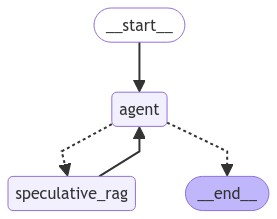

In [11]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [14]:
_now = perf_counter()
async for event in  compiled_graph.astream_events(
    input={"messages": [("user", "What is Query2doc?")]},
    version="v2"
):
    kind: str = event.get("event")
    if kind == "on_chat_model_stream":
        if token := event.get("data").get("chunk").content:
            print(token, end="", flush=True) 
logger.info("Time to generate response:  {s:.4f} seconds.", s=perf_counter() - _now)

2024-08-27 21:45:37.006 | INFO     | __main__:should_continue:25 - [{'name': 'get_relevant_information', 'args': {'query': 'Query2doc'}, 'id': 'call_cFyZUW75f7Nq2B7zlptXBBtB', 'type': 'tool_call'}]
2024-08-27 21:45:37.052 | INFO     | __main__:speculative_rag:20 - Generating query vector...
2024-08-27 21:45:37.511 | INFO     | __main__:speculative_rag:26 - Query vector generated in 0.4582 seconds.
2024-08-27 21:45:37.511 | INFO     | __main__:speculative_rag:29 - Fetching relevant documents...
2024-08-27 21:45:37.513 | INFO     | __main__:speculative_rag:34 - Documents retrieved in 0.0013 seconds.
2024-08-27 21:45:37.513 | INFO     | __main__:speculative_rag:37 - Doing Multi Perspective Sampling...
2024-08-27 21:45:37.514 | INFO     | __main__:multi_perspective_sampling:5 - Finding 2 clusters.
2024-08-27 21:45:37.517 | INFO     | __main__:multi_perspective_sampling:17 - Clusters distribution: {1: [0, 2, 3, 4, 7, 9], 0: [1, 5, 6, 8]}
2024-08-27 21:45:37.521 | INFO     | __main__:multi_p

Query2doc is a method that uses large language models (LLMs) for query expansion by generating pseudo-documents from the original query. This approach is designed to enhance the performance of existing retrieval systems by adding generated content. Despite its simplicity, query2doc has been shown to consistently improve retrieval outcomes across different models and datasets. However, it does introduce some challenges, such as increased latency due to the slow inference of LLMs and potentially longer search times in inverted indexes. Therefore, while it offers significant benefits, practical deployment must consider these efficiency trade-offs.

2024-08-27 21:45:45.650 | INFO     | __main__:<module>:10 - Time to generate response:  9.3337 seconds.
